In [1]:
import pickle as pkl
import pk_plot_library as pplib
import numpy as np
import matplotlib.pyplot as plt
from figrid.data_container import DataContainer
import copy

DRAFTPATH = '/Users/cosinga/overleaf/hicolor_draft_two/figures/'
SAVEPATH = '/Users/cosinga/code/hcolor/fig_md_analysis/rvb/'
WEBPATH = '/Users/cosinga/code/calvinosinga.github.io/hicolor/sup_analysis/'
pplib.imports()

def fill_mean(ax, data, kwargs):
    x = data[0]
    y = np.mean(np.array([data[1], data[2]]), axis = 0)
    kwargs['alpha'] = 1
    ax.plot(x, y, **kwargs)
    return


In [2]:
ds = pkl.load(open('/Users/cosinga/code/hcolor/fig_md_analysis/11-6_pkdatasort.pkl', 'rb'))

ds.tickArgs(direction = 'in', labelsize = 14)
ds.legendArgs(frameon = False, loc = 'upper right', fontsize = 12, slc = (-1, -1))

ds.rowLabelArgs(pos = [0.05, 0.05], fontsize = 16, ha = 'left', va = 'bottom')
ds.colLabelArgs(pos = [0.5, 0.95], fontsize = 16, ha = 'center', va = 'top')

ds.axisArgs(xscale = 'log', yscale = 'log', xlim = [0.04, 10])
ds.axisLabelArgs('both', fontsize = 16)
ds.setOrder('space', ['real', 'redshift', 'rsd'])
ds.setOrder('snapshot', [99, 67, 50])

ds.displayAs('space', ['real', 'redshift', 'rsd'], ['Real Space', 'Redshift Space', 'Redshift Space\nDistortions'])
ds.displayAs('HI_fieldname', ['hisubhalo', 'vn', 'hiptl'], ['Galaxy Centers', 'All Particles', 'Particles in Galaxies'])
ds.displayAs('snapshot', [99, 67, 50], ['z = 0.0', 'z = 0.5', 'z = 1.0'])
ds.displayAs('color', ['red', 'blue', 'resolved', 'ratio'],
            ['HI $\\times$ Red\nCross-Power', 'HI $\\times$ Blue\nCross-Power',
            'HI $\\times$ Galaxy\nCross-Power', r'Color Ratio'])
ds.displayAs('post_process', ['corr_coef', 'theory_bias', 'obs_bias'], 
             ['r', '$b_{\\mathrm{th}}$', '$b_{\\mathrm{obs}}$'])

ds.setColors('post_process', ['pink', 'lime', 'cyan'], ['corr_coef', 'theory_bias', 'obs_bias'])
ds.setColors('color', ['red', 'blue', 'gray'], ['red', 'blue', 'resolved'])
ds.setColors('space', ['green', 'orange'], ['real', 'redshift'])
ds.setColors('HI_fieldname', ['firebrick', 'saddlebrown', 'sandybrown'], ['vn', 'hiptl', 'hisubhalo'])
snapshots = ds.getAttrVals('snapshot')
snapshots.sort()
snapshots.reverse()
ds.setColors('snapshot', 'viridis', snapshots)

ds.setXLabel(pplib.wnum())

In [3]:
def calc_obs_bias(ip):
    ptlip = {'is_auto':True, 'fieldname':'ptl', 'ptl_species':'ptl', 'mas':ip['mas'],
            'path':ip['path'], 'grid_resolution':ip['grid_resolution'],
            'simname':ip['simname'], 'axis':0, 'snapshot':ip['snapshot'],
            'space':ip['space']}
    ptl_auto = ds.getMatching(ptlip)
    if len(ptl_auto) > 1:
        print('found too many particles')
        for i in ptl_auto:
            print(i.attrs)
    
    ptl_auto = ptl_auto[0]
    
    auto = ds.getMatching(ip)
    biases = []
    for i in range(len(auto)):
        
        data = [auto[i].data[0], np.sqrt(auto[i].data[1] / ptl_auto.data[1])]
        dc = DataContainer(data)
        dc.update(copy.deepcopy(auto[i].attrs))
        dc.add('post_process','obs_bias')
        dc.add('is_auto', False)
        dc.add('denominator', 'ptl')
        dc.add('_post_time', 'now')

        biases.append(dc)
    return biases

def calc_th_bias(ip):
    ptlip = {'is_auto':True, 'fieldname':'ptl', 'ptl_species':'ptl', 'mas':ip['mas'],
            'path':ip['path'], 'grid_resolution':ip['grid_resolution'],
            'simname':ip['simname'], 'axis':0, 'snapshot':ip['snapshot'],
            'space':ip['space']}
    ptl_auto = ds.getMatching(ptlip)
    if len(ptl_auto) > 1:
        print('found too many particles')
        for i in ptl_auto:
            print(i.attrs)
    
    ptl_auto = ptl_auto[0]
    
    cross = ds.getMatching(ip)
    biases = []
    for i in range(len(cross)):
        
        data = [cross[i].data[0], cross[i].data[1] / ptl_auto.data[1]]
        dc = DataContainer(data)
        dc.update(copy.deepcopy(cross[i].attrs))
        dc.add('post_process','theory_bias')
        dc.add('denominator', 'ptl')
        dc.add('_post_time', 'now')
        biases.append(dc)
    return biases
def save_bias(biases):
    SAVE_ATTRS = ['simname', 'snapshot', 'space', 'post_process', 'color', 'model']
    bvals = []
    for bias in biases:
        bval = np.mean(bias.getData()[1][:2])
        attrs = [bias.get(attr) for attr in SAVE_ATTRS]
        bvals.append([bval, attrs])
    return bvals

In [4]:
simnames = ['tng100', 'tng300']
snapshots = [50, 67, 99]
spaces = ['real', 'redshift']
bvals = []
for name in simnames:
    for snap in snapshots:
        for space in spaces:
            
            
            print("\n", name, snap, space)
            hiip = {'is_auto':True, "HI_fieldname":['vn', 'hiptl'],      
              'axis':0, 'grid_resolution':800, 'simname': name,
              'mas':'CICW', 'snapshot':snap, 'space':space,
             'path':'fiducial', 'post_process':'no key found'}
            obs_biases = calc_obs_bias(hiip)
            print('hi biases:', len(obs_biases))
            ds.extend(obs_biases)
            bvals.extend(save_bias(obs_biases))
            galip = {'gal_res':'diemer',
                      'gal_species':'stmass', 'sim_resolution':'high', 
                     'axis':0, 'grid_resolution':800,
                      'censat':['no key found', 'both'], 'mas':'CICW', 
                     'color': ['blue', 'red', 'resolved'], 'fieldname':'galaxy',
                     'path':'fiducial', 'simname':name, 'space':space,
                    'snapshot':snap, 'post_process':'no key found'}
            obs_biases = calc_obs_bias(galip)
            print('galaxy biases:', len(obs_biases))
            bvals.extend(save_bias(obs_biases))
            ds.extend(obs_biases)


 tng100 50 real
hi biases: 5
galaxy biases: 3

 tng100 50 redshift
hi biases: 5
galaxy biases: 3

 tng100 67 real
hi biases: 5
galaxy biases: 3

 tng100 67 redshift
hi biases: 5
galaxy biases: 3

 tng100 99 real
hi biases: 5
galaxy biases: 3

 tng100 99 redshift
hi biases: 5
galaxy biases: 3

 tng300 50 real
hi biases: 5
galaxy biases: 3

 tng300 50 redshift
hi biases: 5
galaxy biases: 3

 tng300 67 real
hi biases: 5
galaxy biases: 3

 tng300 67 redshift
hi biases: 5
galaxy biases: 3

 tng300 99 real
hi biases: 5
galaxy biases: 3

 tng300 99 redshift
hi biases: 5
galaxy biases: 3


In [5]:
# printing out the bias values

for b in bvals:
    if 'tng300' in b[1] and 'real' in b[1]:
        print(b)
    

[1.2716512128067996, ['tng300', 50, 'real', 'obs_bias', 'no key found', 'no key found']]
[1.2922515257771614, ['tng300', 50, 'real', 'obs_bias', 'no key found', 'GD14']]
[1.2896232698945633, ['tng300', 50, 'real', 'obs_bias', 'no key found', 'GK11']]
[1.269207806165343, ['tng300', 50, 'real', 'obs_bias', 'no key found', 'K13']]
[1.2705451703719024, ['tng300', 50, 'real', 'obs_bias', 'no key found', 'S14']]
[1.7711445281737193, ['tng300', 50, 'real', 'obs_bias', 'blue', 'no key found']]
[2.6305088368640592, ['tng300', 50, 'real', 'obs_bias', 'red', 'no key found']]
[2.0650771760034363, ['tng300', 50, 'real', 'obs_bias', 'resolved', 'no key found']]
[0.9831357038509602, ['tng300', 67, 'real', 'obs_bias', 'no key found', 'GD14']]
[0.9874326220460574, ['tng300', 67, 'real', 'obs_bias', 'no key found', 'GK11']]
[0.9885502604430069, ['tng300', 67, 'real', 'obs_bias', 'no key found', 'K13']]
[0.9923024808099763, ['tng300', 67, 'real', 'obs_bias', 'no key found', 'S14']]
[0.9746945268048979, [

In [6]:
from colossus.cosmology import cosmology
cosmo = cosmology.setCosmology('planck15')
def kaiser(z, bias):
    D = cosmo.growthFactor(z, derivative = 0)
    dDdz = cosmo.growthFactor(z, derivative = 1)
    f = -dDdz * (z + 1) / D
    beta = f / bias
    return (1 + 2/3 * beta + 1/5 * beta**2)
def Plin(k, z):
    return cosmo.matterPowerSpectrum(k, z)

# Ideal Case: Cross-Correlations with Perfect Measurements

The first test we want to do to test this - constraints are based on the assumption that <br>

$P_{\rm{HI} \times \rm{gal}}^s (k) = b_{\rm{HI}}^{s} b_{\rm{gal}}^{s} r_{\rm{HI-gal}}^{s} P_{m}^s (k)$ <br>

is true. We extract the HI and galaxy bias and their correlation coefficients directly from the simulation by averaging the bias at the two largest k values (averaged to mitigate cosmic variance issues). For values with multiple HI models, we also take their median value.

In [7]:
# getting dict of bias values
breds = {}
bblues = {}
bgals = {}
bhis = {50:[], 67:[], 99:[]}
for b in bvals:
    if 'tng300' in b[1] and 'redshift' in b[1]:
        if 'red' in b[1]:
            breds[b[1][1]] = b[0]
        elif 'blue' in b[1]:
            bblues[b[1][1]] = b[0]
        elif 'resolved' in b[1]:
            bgals[b[1][1]] = b[0]
        else:
            bhis[b[1][1]].append(b[0])
for k,v in bhis.items():
    bhis[k] = np.median(np.array(v))
bhis, bblues, bgals, breds

({50: 1.2087606963424382, 67: 0.9881842732707884, 99: 0.7825156368210284},
 {50: 1.6037731406034428, 67: 1.2282218237977882, 99: 0.9235303108078625},
 {50: 1.8341157041210767, 67: 1.5863277137530967, 99: 1.3917337811206063},
 {50: 2.270868458848555, 67: 1.9188763134676918, 99: 1.5580867622760421})

In [8]:
ip = {'is_auto':False, 'post_process':'corr_coef', 'HI_fieldname':['vn', 'hiptl'], 'space':['real', 'redshift'], 'gal_res':'diemer',
      'gal_species':'stmass', 'snapshot':[99, 67, 50], 'simname':'tng300',
      'censat':['no key found', 'both'], 'mas':'CICW', 'color': ['red', 'blue', 'resolved'],
     'path':'fiducial'}
ccs = ds.getMatching(ip)
ccblue = {50:[], 67:[], 99:[]}
ccred = {50:[], 67:[], 99:[]}
ccgal = {50:[], 67:[], 99:[]}
for i, cc in enumerate(ccs):
    ccval = np.mean(cc.getData()[1][:2])
    if cc.isMatch({'color':'blue', 'space':'redshift'}):
        ccblue[cc.get('snapshot')].append(ccval)
    elif cc.isMatch({'color':'red', 'space':'redshift'}):
        ccred[cc.get('snapshot')].append(ccval)
    elif cc.isMatch({'color':'resolved', 'space':'redshift'}):
        ccgal[cc.get('snapshot')].append(ccval)
for k,v in ccblue.items():
    ccblue[k] = np.median(np.array(v))
for k,v in ccred.items():
    ccred[k] = np.median(np.array(v))
for k,v in ccgal.items():
    ccgal[k] = np.median(np.array(v))
ccblue, ccgal, ccred

({50: 0.9856806187856864, 67: 0.9898796544723056, 99: 0.9911138338874372},
 {50: 0.9771400735518803, 67: 0.9707501548485626, 99: 0.9550958938886307},
 {50: 0.9389379160177165, 67: 0.9466665652447258, 99: 0.9400639771516298})

In [15]:
ip = {'is_auto':False, 'HI_fieldname':['vn','hiptl'], 
      'axis':0, 'grid_resolution':800, 'simname': 'tng300', 
      'snapshot':[99, 67, 50], 'color_cut':['0.60', '0.55', '0.50', 'None'], 'gal_res':'diemer',
      'gal_species':'stmass', 'sim_resolution':'high', 'post_process':'no key found',
      'mas':'CICW',
     'color':['blue', 'red', 'resolved'], 'space':['redshift']}
ptlpk = ds.getMatching({'is_auto':True, 'fieldname':'ptl', 'ptl_species':'ptl', 'mas':ip['mas'],
            'path':'fiducial', 'grid_resolution':ip['grid_resolution'],
            'simname':ip['simname'], 'axis':0, 'snapshot':99,
            'space':'redshift'})
ptlk99 = ptlpk[0].getData()[0]
pklin99 = Plin(ptlk99, 0) * kaiser(0, 1)
ptlpk99 = ptlpk[0].getData()[1]
ptlpk = ds.getMatching({'is_auto':True, 'fieldname':'ptl', 'ptl_species':'ptl', 'mas':ip['mas'],
            'path':'fiducial', 'grid_resolution':ip['grid_resolution'],
            'simname':ip['simname'], 'axis':0, 'snapshot':67,
            'space':'redshift'})
ptlk67 = ptlpk[0].getData()[0]
ptlpk67 = ptlpk[0].getData()[1]
pklin67 = Plin(ptlk99, ptlpk[0].get('redshift')) * kaiser(ptlpk[0].get('redshift'), 1)
ptlpk = ds.getMatching({'is_auto':True, 'fieldname':'ptl', 'ptl_species':'ptl', 'mas':ip['mas'],
            'path':'fiducial', 'grid_resolution':ip['grid_resolution'],
            'simname':ip['simname'], 'axis':0, 'snapshot':50,
            'space':'redshift'})
ptlk50 = ptlpk[0].getData()[0]
ptlpk50 = ptlpk[0].getData()[1]
pklin50 = Plin(ptlk99, ptlpk[0].get('redshift'))

The row values for snapshot: [99, 67, 50]
The column values for color: ['blue', 'red', 'resolved']


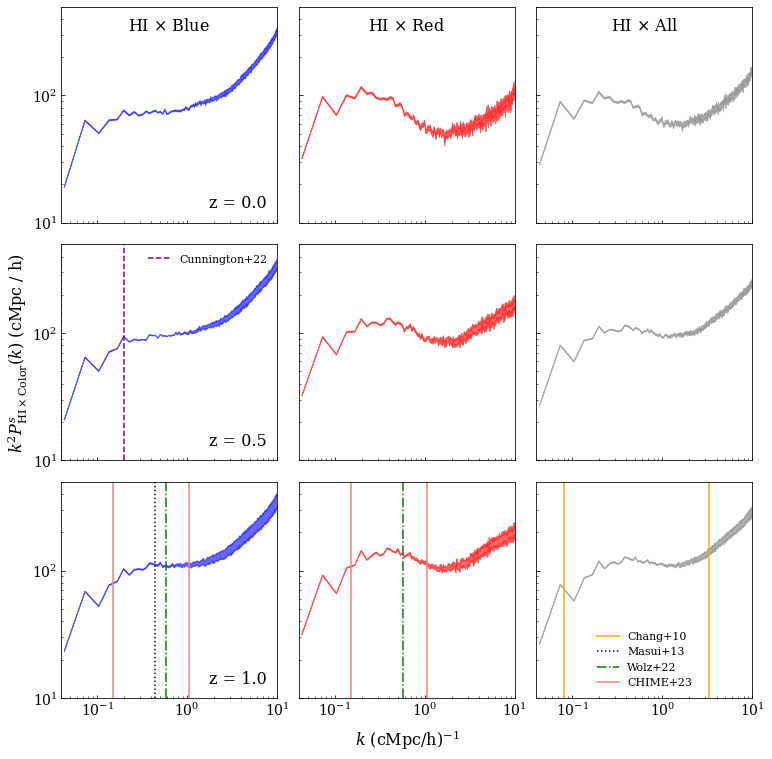

In [20]:
def renorm(dc):
    data = dc.getData()
    data[1] = data[0]**2 * data[1]
    dc.setData(data)
    return dc

def obs_range(ax, kmin, kmax, **kwargs):
    ylim = ax.get_ylim()
    handle = ax.fill_betweenx(ylim, kmin, kmax, **kwargs)
    return handle

fg = ds.figrid('color', 'snapshot', 'color', ip)
fg.gspecArgs(wspace = 0.1, hspace = 0.1)
fg.adjustData({}, renorm)
# fg.plotArgs({'color':'resolved'}, label = 'HI $\\times$ Color')
fg.plotArgs({}, label = '__nolegend__')
fg.axisArgs(ylim = (10,5e2))
fg.autoFill(alpha = 0.6)
fg.setYLabel("$k^2 P^s_{\\rm{HI} \\times \\rm{Color}}(k)$ (cMpc / h)")
fg.setDefaultTicksParams()
fg.colLabels(['HI $\\times$ Blue', 'HI $\\times$ Red', 'HI $\\times$ All'])
fg.rowLabels(pos = (0.95, 0.05))
fg.rowLabelArgs(ha = 'right')
fg.legendArgs(rm_legend = True)
fg.plot()
# z = 1 k-line plots
for i in range(3):
    ax = fg.axes[2, i]
    if i == 0:
        masui_col = 'black'
        masui = ax.axvline(0.44, linestyle = 'dotted', color = masui_col)
        ax.axvline(0.027, linestyle = 'dotted', color = masui_col)
    if i == 2:
        chang_col = 'orange'
        chang = ax.axvline(3.28, linestyle = 'solid', color = chang_col)
        ax.axvline(0.08, linestyle = 'solid', color = chang_col)
    if not i == 2:
        wolz_col = 'green'
        wolz = ax.axvline(0.03, linestyle = 'dashdot', color = wolz_col)
        ax.axvline(0.58, linestyle = 'dashdot', color = wolz_col)
        chime_col = 'salmon'
        chime = ax.axvline(0.15, linestyle = 'solid', color = chime_col)
        ax.axvline(1.05, linestyle = 'solid', color = chime_col)

labels = ['Chang+10', 'Masui+13', 'Wolz+22', 'CHIME+23']
fg.axes[2,2].legend(handles = [chang, masui, wolz, chime], labels = labels, frameon = False, loc = 'lower center', fontsize = 11)

# z = 0.5 k-line plots
for i in range(3):
    ax = fg.axes[1, i]
    if i == 0:
        cunn_col = 'purple'
        cunn = ax.axvline(0.04, linestyle = 'dashed', color = cunn_col)
        ax.axvline(0.197, linestyle = 'dashed', color = cunn_col)
    
labels = ['Cunnington+22']
fg.axes[1,0].legend(handles = [cunn], labels = labels, frameon = False, loc = 'upper right', fontsize = 11)

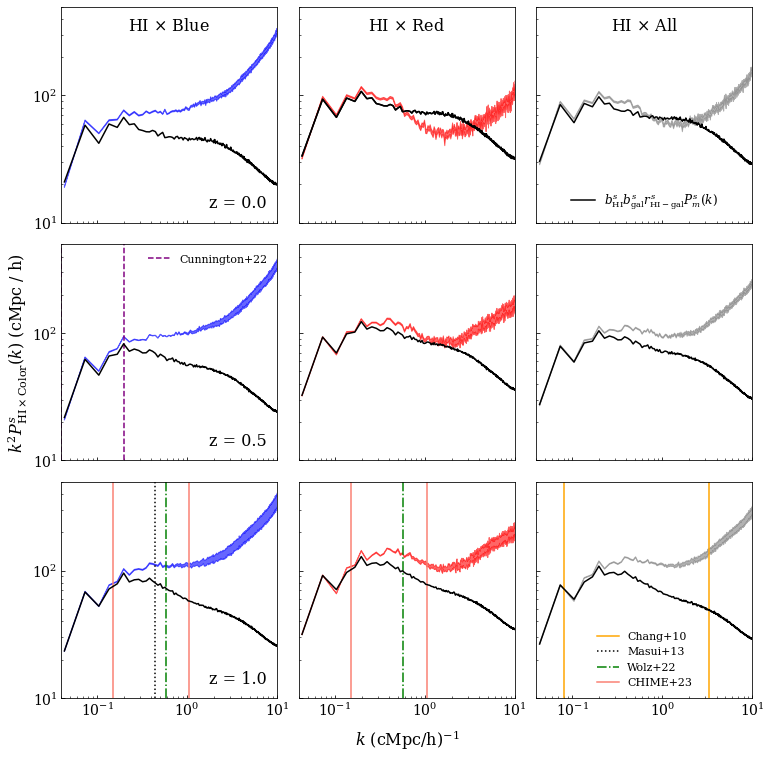

In [21]:
model_equation = r'$b_{\rm{HI}}^s b_{\rm{gal}}^s r_{\rm{HI-gal}}^s P_{m}^s (k)$'
blueax = fg.axes[0,0]
blueax.plot(ptlk99, ptlpk99 * bhis[99] * bblues[99] * ccblue[99] * ptlk99**2, color = 'black', label = 'model')
blueax = fg.axes[1,0]
blueax.plot(ptlk67, ptlpk67 * bhis[67] * bblues[67] * ccblue[67] * ptlk67**2, color = 'black', label = 'model')
redax = fg.axes[0,1]
redax.plot(ptlk99, ptlpk99 * bhis[99] * breds[99] * ccred[99] * ptlk99**2, color = 'black', label = 'model')
redax = fg.axes[1,1]
redax.plot(ptlk67, ptlpk67 * bhis[67] * breds[67] * ccred[67] * ptlk67**2, color = 'black', label = 'model')
redax = fg.axes[2,1]
redax.plot(ptlk50, ptlpk50 * bhis[50] * breds[50] * ccred[50] * ptlk50**2, color = 'black', label = 'model')
galax = fg.axes[2,2]
galax.plot(ptlk50, ptlpk50 * bhis[50] * bgals[50] * ccgal[50] * ptlk50**2, color = 'black', label = 'model')
galax = fg.axes[0,2]
galax.plot(ptlk99, ptlpk99 * bhis[99] * bgals[99] * ccgal[99] * ptlk99**2, color = 'black', label = model_equation)
galax.legend(loc = 'lower center', frameon = False, fontsize = 12)
galax = fg.axes[1,2]
galax.plot(ptlk67, ptlpk67 * bhis[67] * bgals[67] * ccgal[67] * ptlk67**2, color = 'black', label = 'model')
redax = fg.axes[0,1]
redax.plot(ptlk99, ptlpk99 * bhis[99] * breds[99] * ccred[99] * ptlk99**2, color = 'black', label = 'model')
blueax = fg.axes[2, 0]
blueax.plot(ptlk50, ptlpk50 * bhis[50] * bblues[50] * ccblue[50] * ptlk50**2, color = 'black', label = 'model')
fg.fig

Comparison of the cross-power spectra between HI and blue (left), red (center), and all (right) galaxies and the model at z = 1, 0.5, 0. The power spectra are rescaled by $k$ in order to reduce the dynamic range. Even in the ideal scenario, where we can perfectly measure the cross-power spectrum and the bias / correlation coefficients, IllustrisTNG predicts that assuming the linear values of galaxy, HI, and cc introduces errors . 

In [14]:
ip = {'is_auto':False, 'HI_fieldname':['vn','hiptl'], 
      'axis':0, 'grid_resolution':800, 'simname': 'tng300', 
      'snapshot':[99, 67, 50], 'color_cut':['0.60', '0.55', '0.50', 'None'], 'gal_res':'diemer',
      'gal_species':'stmass', 'sim_resolution':'high', 'post_process':'no key found',
      'mas':'CICW',
     'color':['blue', 'red', 'resolved'], 'space':['redshift']}
ptlpk = ds.getMatching({'is_auto':True, 'fieldname':'ptl', 'ptl_species':'ptl', 'mas':ip['mas'],
            'path':'fiducial', 'grid_resolution':ip['grid_resolution'],
            'simname':ip['simname'], 'axis':0, 'snapshot':99,
            'space':'redshift'})
ptlk99 = ptlpk[0].getData()[0]
ptlpk99 = ptlpk[0].getData()[1] * kaiser(0, 1)



In [29]:
bias_dict = {'HI':bhis, 'blue':bblues, 'red':breds, 'resolved':bgals}
cc_dict = {'blue':ccblue, 'red':ccred, 'resolved':ccgal}
linval_dict = {'cc':cc_dict, 'b':bias_dict}

# create data containers
from figrid.data_container import DataContainer

ip = {'simname':'tng300', 'fieldname':'ptl', 'space':'real', 'ptl_species':'ptl'}
dcip = {'space':'redshift', 'fieldname' : 'model_fiducial', 'simname':'tng300'}
for ss in [50, 67, 99]:
    for col in ['blue', 'red', 'resolved']:
        ip['snapshot'] = ss
        ptldc = ds.getMatching(ip)
        new_data = ptldc[0].getData().copy()
        biashi = linval_dict['b']['HI'][ss]
        biasgal = linval_dict['b'][col][ss]
        cchigal = linval_dict['cc'][col][ss]
        new_data[1] = new_data[1] * kaiser(ptldc[0].get('redshift'), 1) * biashi * biasgal * cchigal
        dc = DataContainer(new_data)
        dcip['color'] = col
        dcip['snapshot'] = ss
        dc.update(dcip)
        ds.append(dc)
        

In [30]:
pkl.dump(linval_dict, open("linval.pkl", 'wb'))
pkl.dump(ds, open("ds_bias.pkl", 'wb'))